In [1]:
import sys
import os

parent_path = ".."
sys.path.append(os.path.abspath(parent_path))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from health_causenet.causenet import (
    contrastive_weight,
    term_domain_specificity,
    constants,
)

plt.rcParams["font.family"] = "serif"

2022-09-21 12:31:37.439005: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-21 12:32:42.461178: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-21 12:32:42.469028: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-21 12:32:42.469069: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: gammaweb06
2022-09-21 12:32:42.469079: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: gammaweb06
2022-09-21 12:32:42.469243: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: Not found: was unable to find libcuda.so DSO loaded into this program
2022-09-21 12:32:42.469284: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version

In [3]:
# load cf and compute termhood scores
cf = pd.read_parquet(os.path.join(constants.CF_PATH, "cf.parquet"))
cf.loc[cf.num_terms == 1].sum().astype(str)

corpus_frequency_open_domain       2956489149.0
corpus_frequency_pubmed            3780908995.0
corpus_frequency_pubmed_central    5395154471.0
corpus_frequency_textbook            13915204.0
corpus_frequency_encyclopedia         9325699.0
num_terms                            25315236.0
dtype: object

In [7]:
medical_termhood = {}
for corpus in list(cf.filter(regex=r".*_frequency_(?!open_domain)")):
    _cf = cf.loc[:, ["corpus_frequency_open_domain", corpus, "num_terms"]]
    corpus = corpus.replace("corpus_frequency_", "")
    medical_termhood[corpus] = {}
    print(f"{corpus}: computing term domain specificity...")
    medical_termhood[corpus]["term_domain_specificity"] = term_domain_specificity(
        _cf, np.e
    )
    print(f"{corpus}: computing contrastive weight...")
    medical_termhood[corpus]["contrastive_weight"] = contrastive_weight(_cf, np.e, 1)
    print(f"{corpus}: computing_discriminative weight...")
    medical_termhood[corpus]["discriminative_weight"] = (
        medical_termhood[corpus]["contrastive_weight"]
        * medical_termhood[corpus]["term_domain_specificity"]
    )

pubmed: computing term domain specificity...
pubmed: computing contrastive weight...
pubmed: computing_discriminative weight...
pubmed_central: computing term domain specificity...
pubmed_central: computing contrastive weight...
pubmed_central: computing_discriminative weight...
textbook: computing term domain specificity...
textbook: computing contrastive weight...
textbook: computing_discriminative weight...
encyclopedia: computing term domain specificity...
encyclopedia: computing contrastive weight...
encyclopedia: computing_discriminative weight...


In [5]:
terms = ["actor", "carcinoma", "diagnosis", "study", "the", "ward"]

In [6]:
cf.loc[terms]

,corpus_frequency_open_domain,corpus_frequency_pubmed,corpus_frequency_pubmed_central,corpus_frequency_textbook,corpus_frequency_encyclopedia,num_terms
term,,,,,,
actor,539080.0,5590.0,16485.0,60.0,6.0,1
carcinoma,7410.0,987164.0,563780.0,290.0,978.0,1
diagnosis,34218.0,1851514.0,2064083.0,3700.0,4536.0,1
study,508740.0,10630098.0,19199951.0,14061.0,1570.0,1
the,196374618.0,200926211.0,327333498.0,761916.0,534780.0,1
ward,186811.0,47099.0,120100.0,689.0,48.0,1


In [17]:
def plot_termhood_hist(
    contrastive_score,
    corpus,
    terms,
    ax=None,
    legend=True,
    linewidth=3,
    markersize=10,
    markerheight=0.25,
    abbreviate=True,
):

    rename_dict = {
        "pubmed": "PubMed",
        "encyclopedia": "Encyclopedia",
    }

    values = medical_termhood[corpus][contrastive_score]
    valid = cf.num_terms == 1
    valid = valid & (cf[f"corpus_frequency_{corpus}"] > 0)
    valid = valid & (cf[f"corpus_frequency_open_domain"] > 0)
    values = values.loc[valid]
    values = values.loc[values != 0]
    values = values
    term_values = values.loc[terms]
    max_term_value = term_values.max()
    term_values = term_values.to_dict()
    values = values.loc[values <= max_term_value * 1.05]

    if ax is None:
        ax = values.dropna().hist(bins=30, grid=False)
    else:
        values.dropna().hist(bins=30, grid=False, ax=ax)

    ax.set_title(rename_dict.get(corpus, corpus))

    split = contrastive_score.split("_")
    xlabel = " ".join(split).title()
    if abbreviate:
        xlabel += f" ({''.join(word[0] for word in split)})".upper()
    ax.set_xlabel(xlabel)

    max_height = max(patch.get_height() for patch in ax.patches)
    markers = ["o", "^", "s", "P", "*", "D"]
    for idx, (term, value) in enumerate(term_values.items()):
        ax.plot(
            [value, value],
            [0, max_height * markerheight],
            label=term,
            linewidth=linewidth,
            marker=markers[idx % len(markers)],
            markersize=markersize,
            markevery=(1, 1),
        )

    if legend:
        _legend = ax.legend(handlelength=0, ncol=2)
        _legend.get_frame().set_linewidth(0.0)

    fig = ax.get_figure()
    return fig

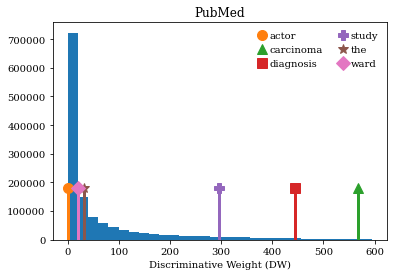

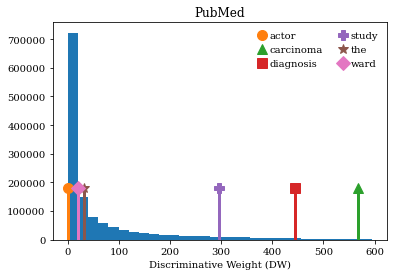

In [24]:
plot_termhood_hist("discriminative_weight", "pubmed", terms)

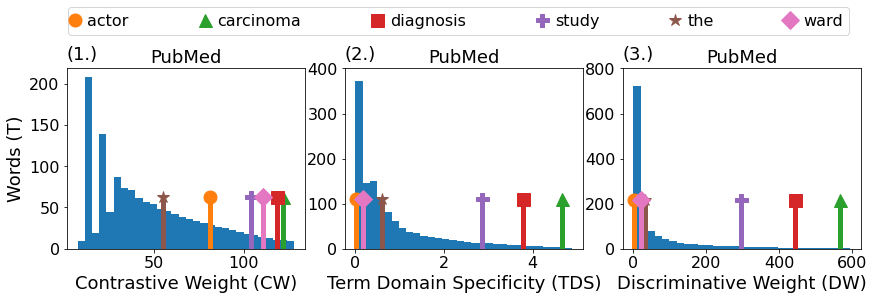

In [70]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 18

plt.rcParams["font.family"] = "sans"

plot_variants = [
    ("pubmed", "contrastive_weight"),
    ("pubmed", "term_domain_specificity"),
    ("pubmed", "discriminative_weight"),
#     ("encyclopedia", "discriminative_weight"),
]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.5))
labels = ["(1.)", "(2.)", "(3.)"]
for idx, (ax, label, (_corpus, _score)) in enumerate(zip(axes, labels, plot_variants)):
    fig = plot_termhood_hist(
        _score,
        _corpus,
        terms,
        ax,
        legend=False,
        linewidth=5,
        markersize=13,
        markerheight=0.3,
    )
#     add (x) plot labels
    _text = ax.text(0, 1.05, label, transform=ax.transAxes, size=LARGE_SIZE)
    if idx % 2 == 1:
        _text.set_in_layout(False)

# set y_label
axes[0].set_ylabel("Words (T)", size=LARGE_SIZE)

# remove border of legend
# legend = axes[0].legend(
#     handlelength=0, ncol=2, columnspacing=0.6, borderaxespad=0.1, fontsize=MEDIUM_SIZE
# )
# legend.get_frame().set_linewidth(0.0)
fig.legend(
    ax.lines,
    terms,
    handlelength=0,
    columnspacing=4.75,
    ncol=len(terms),
    loc="upper center",
    bbox_to_anchor=(0.525, 1.175),
    fontsize=MEDIUM_SIZE
)

# remove 0's from axis ticks
plt.tight_layout(pad=0.2)
for ax in fig.get_axes():
    y_ticks = ax.get_yticks()
    y_ticks = y_ticks[::2]
    y_tick_labels = [str(int(y_tick / 1000)) for y_tick in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(labelsize=MEDIUM_SIZE)
    ax.set_xlabel(ax.get_xlabel(), size=LARGE_SIZE)
    ax.set_title(ax.get_title(), size=LARGE_SIZE)

plt.tight_layout(pad=0.2)
fig.savefig(f"figures/termhood-comparison-histogram.pdf", bbox_inches="tight")

plt.rcParams["font.family"] = "serif"

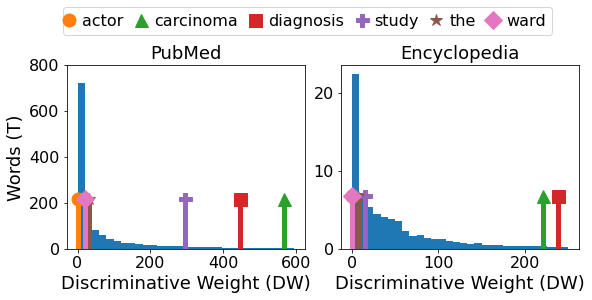

In [71]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 18

plt.rcParams["font.family"] = "sans"

plot_variants = [
#     ("pubmed", "contrastive_weight"),
#     ("pubmed", "term_domain_specificity"),
    ("pubmed", "discriminative_weight"),
    ("encyclopedia", "discriminative_weight"),
]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5))
labels = ["(1.)", "(2.)", "(3.)"]
for idx, (ax, label, (_corpus, _score)) in enumerate(zip(axes, labels, plot_variants)):
    fig = plot_termhood_hist(
        _score,
        _corpus,
        terms,
        ax,
        legend=False,
        linewidth=5,
        markersize=13,
        markerheight=0.3,
    )
#     add (x) plot labels
#     _text = ax.text(0, 1.05, label, transform=ax.transAxes, size=LARGE_SIZE)
#     if idx % 2 == 1:
#         _text.set_in_layout(False)

# set y_label
axes[0].set_ylabel("Words (T)", size=LARGE_SIZE)

# remove border of legend
# legend = axes[0].legend(
#     handlelength=0, ncol=2, columnspacing=0.6, borderaxespad=0.1, fontsize=MEDIUM_SIZE
# )
# legend.get_frame().set_linewidth(0.0)
fig.legend(
    ax.lines,
    terms,
    handlelength=0,
    columnspacing=1.1,
    ncol=len(terms),
    loc="upper center",
    bbox_to_anchor=(0.525, 1.175),
    fontsize=MEDIUM_SIZE
)

# remove 0's from axis ticks
plt.tight_layout(pad=0.2)
for ax in fig.get_axes():
    y_ticks = ax.get_yticks()
    y_ticks = y_ticks[::2]
    y_tick_labels = [str(int(y_tick / 1000)) for y_tick in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(labelsize=MEDIUM_SIZE)
    ax.set_xlabel(ax.get_xlabel(), size=LARGE_SIZE)
    ax.set_title(ax.get_title(), size=LARGE_SIZE)

plt.tight_layout(pad=0.2)
fig.savefig(f"figures/termhood-corpora-histogram.pdf", bbox_inches="tight")

plt.rcParams["font.family"] = "serif"

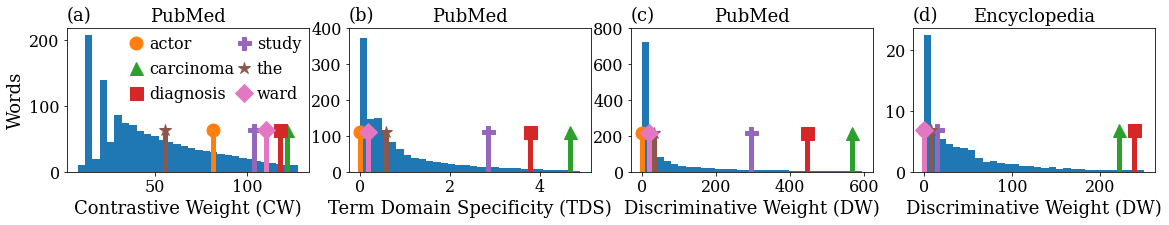

In [23]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 18

plot_variants = [
    ("pubmed", "contrastive_weight"),
    ("pubmed", "term_domain_specificity"),
    ("pubmed", "discriminative_weight"),
    ("encyclopedia", "discriminative_weight"),
]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 3))
labels = ["(a)", "(b)", "(c)", "(d)"]
for idx, (ax, label, (_corpus, _score)) in enumerate(zip(axes, labels, plot_variants)):
    fig = plot_termhood_hist(
        _score,
        _corpus,
        terms,
        ax,
        legend=False,
        linewidth=5,
        markersize=13,
        markerheight=0.3,
    )
    # add (x) plot labels
    _text = ax.text(0, 1.05, label, transform=ax.transAxes, size=LARGE_SIZE)
    if idx % 2 == 1:
        _text.set_in_layout(False)

# set y_label
axes[0].set_ylabel("Words", size=LARGE_SIZE)

# remove border of legend
legend = axes[0].legend(
    handlelength=0, ncol=2, columnspacing=0.6, borderaxespad=0.1, fontsize=MEDIUM_SIZE
)
legend.get_frame().set_linewidth(0.0)
# fig.legend(ax.lines, terms, handlelength=0, borderpad=0.6, loc="center left", bbox_to_anchor=(1, 0.5))

# remove 0's from axis ticks
plt.tight_layout(pad=0.2)
for ax in fig.get_axes():
    y_ticks = ax.get_yticks()
    y_ticks = y_ticks[::2]
    y_tick_labels = [str(int(y_tick / 1000)) for y_tick in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(labelsize=MEDIUM_SIZE)
    ax.set_xlabel(ax.get_xlabel(), size=LARGE_SIZE)
    ax.set_title(ax.get_title(), size=LARGE_SIZE)

plt.tight_layout(pad=0.2)
fig.savefig(f"figures/termhood-histogram.pdf", bbox_inches="tight")

In [25]:
for _corpus in ["pubmed", "encyclopedia"]:
    for _score in [
        "contrastive_weight",
        "term_domain_specificity",
        "discriminative_weight",
    ]:
        print(_corpus, _score)
        fig = plot_termhood_hist(_score, _corpus, terms)
        fig.savefig(f"figures/{_corpus}-{_score}-histogram.pdf", bbox_inches="tight")
        fig.clear(True)

pubmed contrastive_weight
pubmed term_domain_specificity
pubmed discriminative_weight
encyclopedia contrastive_weight
encyclopedia term_domain_specificity
encyclopedia discriminative_weight


<Figure size 432x288 with 0 Axes>

In [42]:
# rank differences
corpus_1 = "encyclopedia"
corpus_2 = "textbook"
score_1 = "term_domain_specificity"
score_2 = "term_domain_specificity"
num_terms = 1
threshold = 50

score_1_scores = medical_termhood[corpus_1][score_1]
score_1_scores = score_1_scores.loc[
    (cf[f"corpus_frequency_{corpus_1}"] >= threshold)
    & (cf.corpus_frequency_open_domain >= threshold)
    & (cf.num_terms == num_terms)
]
score_1_scores = (
    score_1_scores.sort_values().reset_index().reset_index().set_index("term")
)
score_1_rank = score_1_scores.rename({"index": "rank"}, axis=1)["rank"]

score_2_scores = medical_termhood[corpus_2][score_2]
score_2_scores = score_2_scores.loc[
    (cf[f"corpus_frequency_{corpus_2}"] >= threshold)
    & (cf.corpus_frequency_open_domain >= threshold)
    & (cf.num_terms == num_terms)
]
score_2_scores = (
    score_2_scores.sort_values().reset_index().reset_index().set_index("term")
)
score_2_rank = score_2_scores.rename({"index": "rank"}, axis=1)["rank"]

rank_diff = abs(contrastive_rank - specificity_rank)
rank_diff.sort_values(ascending=False).head(30)

term
100f                  3596
hepatosplenomegaly    3586
respirations          3581
nocturia              3576
overactivity          3539
insulinoma            3531
spondylolisthesis     3529
dermatan              3528
ehrlichiosis          3526
dysostosis            3522
dermoid               3516
tenosynovitis         3513
tunnel-like           3513
colorblindness        3513
pylorus               3506
aminophylline         3506
pyogenic              3504
cysticerci            3501
craniotomy            3486
avms                  3477
macrocephaly          3471
ventriculography      3462
faintness             3460
chalazion             3460
menstruate            3459
iugr                  3456
mastocytosis          3455
contagiosum           3455
sun-exposed           3451
mediastinitis         3444
Name: rank, dtype: int64